In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install simtk
!conda update --force conda -y
!conda install -c conda-forge openmm openmmtools mdtraj -y


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Retrieving notices: ...working... done


         See 'conda update --help' for details about the --force-reinstall
         and --clobber flags.


Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::conda==23.7.2=py39h06a4308_0
  - defaults/linux-64::conda-content-trust==0.1.3=py39h06a4308_0
  - defaults/noarch::importlib_metadata==4.11.3=hd3eb1b0_0
  - defaults/linux-64::requests==2.31.0=py39h06a4308_0
  - defaults/linux-64::urllib3==1.26.16=py39h06a4308_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.2
  latest version: 24.1.1

Please update conda by running

    $ conda update -n base -c defaults co

In [14]:
!pip install git+https://github.com/DreamFold/boltzmann-generators.git
!pip install torchsde
!pip install torch==2.0.1+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/noegroup/bgmol git+https://github.com/noegroup/bgflow
!pip install seaborn

  Cloning https://github.com/DreamFold/boltzmann-generators.git to /tmp/pip-req-build-1g597t6h
  Running command git clone --filter=blob:none --quiet https://github.com/DreamFold/boltzmann-generators.git /tmp/pip-req-build-1g597t6h
  Resolved https://github.com/DreamFold/boltzmann-generators.git to commit 64329804ac5250724fcc9812a357f53a192b944e
  Preparing metadata (setup.py) ... done
  Created wheel for boltzgen: filename=boltzgen-0.1-py2.py3-none-any.whl size=22760 sha256=64427a3c35ca46ceef35925cbb532886c4c55822ab134f1089dd3cee5583b26f
  Stored in directory: /tmp/pip-ephem-wheel-cache-glqx6vcd/wheels/76/2e/b0/b12d2aa5345aa6901d6b5f314818ad5a075bbb462decfc4841
Successfully built boltzgen
  Attempting uninstall: boltzgen
    Found existing installation: boltzgen 0.1
    Uninstalling boltzgen-0.1:
      Successfully uninstalled boltzgen-0.1

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is av

In [4]:
!pip install einops


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Issue w error in the next cell is u need to install bgmol from source, i.e.,

```
$ git clone git@github.com:noegroup/bgmol.git
$ python setup.py install
```

In [3]:
from fab.target_distributions.aldp import AldpBoltzmann
from simtk import openmm as mm
from simtk import unit
from simtk.openmm import app
from openmmtools import testsystems
import numpy as np
import mdtraj
import tempfile
import torch
import torchsde

import os
import numpy as np
import mdtraj as md 
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.stats import gaussian_kde
from bgmol.datasets import Ala2TSF300

root = "/mnt/shared_storage/active_inference_data/alanine_dipeptide"
is_data_here = os.path.isfile(root + "/Ala2TSF300.npy")
dataset = Ala2TSF300(root=root, download=(not is_data_here), read=True)
system = dataset.system
coordinates = dataset.coordinates

num_iter_done = 0
def estimate_grad_Rt(x, t, beta=1.0, num_mc_samples=100):
    def grad_fxn(_x, _t):
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        h_t = beta * repeated_t
        
        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * h_t.unsqueeze(1) ** 0.5
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        
        #import pdb; pdb.set_trace()
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    
    norm = torch.linalg.vector_norm(est_scores, dim=-1)
    max_norm = 50
    clip_coeff = torch.clamp(max_norm / (norm+1e-6), max=1)
    clipped_f = est_scores * clip_coeff.unsqueeze(1)
    
    return clipped_f#.clamp(min=-100.0, max=100.0)

def estimate_grad_Rt_vp(x, t, num_mc_samples=100):
    def grad_fxn(_x, _t):
        h_t = _t.repeat_interleave(num_mc_samples).unsqueeze(1)# / global_maxs
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        
        samples = (repeated_x / (1 - repeated_t).sqrt().unsqueeze(1)) + (torch.normal(torch.zeros_like(repeated_x), h_t.sqrt()).to(device))
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores.clamp(min=-100.0, max=100.0)

def true_Rt(x,  h_t):
    target_distrib.convolve(h_t[0])# * (50 ** 2))
    energy = target_distrib.log_prob(x)#unnormalize(x, global_mins, global_maxs))
    target_distrib.reset()
    return energy

def true_Rt_vp(x, h_t):
    target_distrib.convolve(h_t)
    energy = target_distrib.log_prob(x / (1 - h_t).sqrt())#unnormalize(x / (1 - t).sqrt(), global_mins, global_maxs))
    target_distrib.reset()
    return energy

def true_grad_Rt(x, h_t):
    with torch.enable_grad():
        x.requires_grad_()
        samples_energy = true_Rt(x, h_t)
        true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores.detach()

def true_grad_Rt_vp(x, h_t, global_mins=-50, global_maxs=50):
    samples_energy = true_Rt_vp(x, h_t)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores
        
def reward_matching_loss(target, vectorfield, constant_noise_scale, x, t):     
    t = t.unsqueeze(1)
    h_t = constant_noise_scale * t
    
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(noisy_x, t.squeeze())

    estimated_scores = estimate_grad_Rt(noisy_x, t.squeeze(1), beta, 100)
    return ((estimated_scores - pred_scores)**2).mean()

class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5) #+ 0.1

2048it [00:00, 11592354.38it/s]         


In [4]:
target_distrib = AldpBoltzmann()
target_distrib.log_prob(torch.randn((5, 66)))

tensor([-309.3914, -296.6595, -315.6925, -289.2861, -302.4309],
       dtype=torch.float64)

In [5]:
device = torch.device('cpu')

def est_ve_score_wrapper(x, t):
    with torch.enable_grad():
        return estimate_grad_Rt(x, t, beta=beta, num_mc_samples=10)

ve_sde_est_score = VEReverseSDE(est_ve_score_wrapper)

beta = 10.0
num_samples = 100
x1_samples = torch.randn((num_samples, 66)) * beta

In [6]:
t = torch.linspace(0.0, 1.0, 500)
with torch.no_grad():
    est_samples_small_beta_no_clip = torchsde.sdeint(ve_sde_est_score, x1_samples, t, method='euler')

In [7]:
idx = est_samples_small_beta_no_clip[-1].isnan().any(1)
good_samples_small_beta = est_samples_small_beta_no_clip[-1][~idx]

In [8]:
target_distrib.log_prob(good_samples_small_beta)

tensor([-276.4724, -278.6369, -270.4299, -270.4290, -277.4993, -297.6572,
        -279.2190, -277.8176, -274.4274, -277.7410, -285.6282, -286.4087,
        -277.1536, -284.7940, -272.5702, -275.1295, -281.0663, -286.1916,
        -283.6123, -280.5537, -277.7471, -274.7727, -282.9197, -287.9520,
        -277.8465, -270.6425, -278.1082, -273.3493, -276.5413, -277.3747,
        -274.1111, -281.8262, -274.0998, -276.1446, -289.4955, -276.2049,
        -273.4262, -273.7068, -279.8478, -272.7555, -274.2169, -278.2596,
        -268.1424, -286.2138, -275.9165, -287.5086, -282.5208, -276.1092,
        -282.6138, -269.3243, -268.5721, -286.4491, -275.8117, -284.1173,
        -284.0842, -274.0073, -296.3939, -279.3807, -288.0843, -277.7924,
        -285.6951, -276.4112, -301.0992, -278.5569, -282.2602, -277.5070,
        -270.4706, -274.1683, -275.0231, -276.9883, -264.1451, -280.8417,
        -285.5480, -278.0765, -274.0375, -283.7759, -271.1558, -334.2423,
        -273.9873, -283.3787, -274.045

In [91]:
good_samples_small_beta

tensor([[-1.9768e+03,  4.1188e+02, -1.3280e+03,  ..., -1.4857e+00,
         -4.1781e+00, -5.2962e+00],
        [-6.0746e-01,  2.2051e+00, -3.2850e-02,  ..., -5.9837e-01,
          6.7321e+00, -3.5992e-01],
        [ 3.0728e+00,  2.4983e+00, -4.4413e+02,  ...,  2.0854e+00,
          1.8752e+00,  3.6457e-01],
        ...,
        [ 1.2894e+00,  6.0839e-03, -2.2651e-01,  ...,  7.7268e+00,
         -3.9927e+00,  5.9261e+00],
        [-3.4191e-01, -4.1734e-01, -9.3604e-01,  ..., -3.0272e-01,
         -6.4104e+00, -4.2733e+00],
        [ 1.3839e+00,  3.3196e+00, -7.8052e+02,  ...,  2.7216e+00,
         -5.4636e+00,  7.4130e-01]])

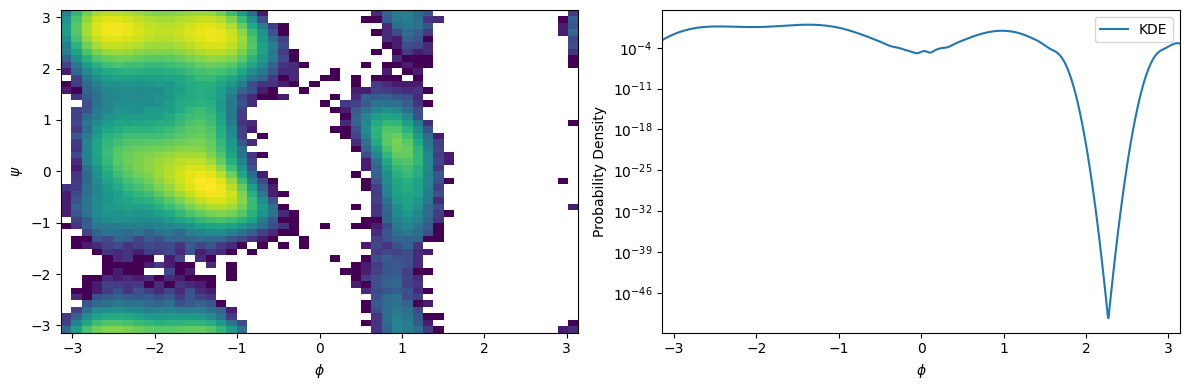

In [17]:
def plot_phi_psi(ax, trajectory, system):
    if not isinstance(trajectory, md.Trajectory):
        trajectory = md.Trajectory(
            xyz=trajectory.cpu().detach().numpy().reshape(-1, 22, 3), 
            topology=system.mdtraj_topology
        )
    phi, psi = system.compute_phi_psi(trajectory)
    
    # 2D histogram plot
    ax.hist2d(phi, psi, bins=50, norm=LogNorm())
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$\psi$")
    
    return phi, psi  # Return computed angles for further analysis

def plot_phi_kde(ax, phi):
    kde = gaussian_kde(phi)
    phi_values = np.linspace(-np.pi, np.pi, 1000)  
    kde_values = kde(phi_values)
    
    # 1D KDE plot
    ax.plot(phi_values, kde_values, label='KDE')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_yscale('log')  
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("Probability Density")
    ax.legend()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 2D Ramachandran plot
phi, psi = plot_phi_psi(ax1, dataset.trajectory, system)

# Plot 1D probability density of phi
plot_phi_kde(ax2, phi)

plt.tight_layout()
plt.show()

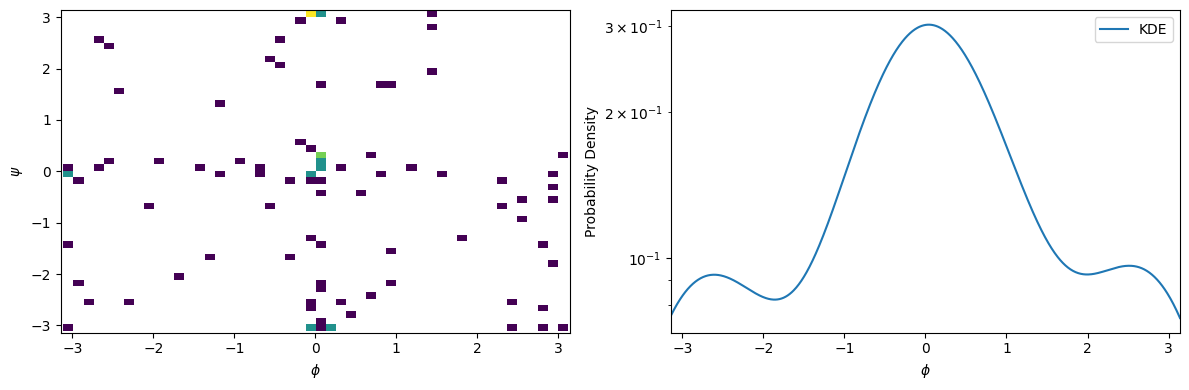

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 2D Ramachandran plot
phi, psi = plot_phi_psi(ax1, good_samples_small_beta, system)

# Plot 1D probability density of phi
plot_phi_kde(ax2, phi)

plt.tight_layout()
plt.show()

In [31]:
target_distrib.log_prob(good_samples).mean()

tensor(-275.0479, dtype=torch.float64)

In [39]:
target_distrib.log_prob(torch.from_numpy(dataset.trajectory[0].xyz.flatten()).unsqueeze(0))

tensor([-259.0913], dtype=torch.float64)

In [43]:
sample_idxs = np.random.permutation(len(dataset.trajectory))[:1000]
mols = torch.stack([torch.from_numpy(dataset.trajectory[i].xyz).flatten() for i in sample_idxs])

In [46]:
target_distrib.log_prob(mols).mean()

tensor(-259.4139, dtype=torch.float64)

In [70]:
mols.std()

tensor(0.2915)

In [56]:
good_samples.max()

tensor(125.6863)

In [64]:
target_distrib.log_prob(est_samples_small_beta_no_clip[-1])

tensor([-269.8020, -271.0602, -272.5453, -265.5813, -266.5697, -265.5579,
        -269.8946, -269.3405, -268.1433, -264.4620, -268.8049, -269.8497,
        -266.0539, -268.6270, -264.9397, -267.8646, -267.3835, -268.6673,
        -269.6827, -268.9888, -267.4526, -266.5174, -264.6989, -268.4758,
        -269.9047, -267.1553, -273.0879, -261.8048, -263.7720, -267.3497,
        -266.4762, -270.4505, -267.8061, -267.5282, -266.0547, -271.4312,
        -268.3707, -270.9602, -263.2872, -261.9697, -274.1019, -270.0280,
        -263.9738, -267.6819, -267.6132, -272.5793, -269.2983, -262.1881,
        -269.0554, -263.6647, -267.0897, -269.2996, -269.1079, -267.4575,
        -266.6395, -268.9693, -268.3158, -265.1698, -268.4153, -264.1187,
        -264.4104, -271.9078, -273.2477, -269.2751, -271.7630, -268.7413,
        -265.9354, -267.5664, -262.4032, -267.9473, -266.9617, -268.7876,
        -265.0408, -270.1274, -265.1944, -269.3065, -265.9151, -262.9032,
        -269.9961, -266.8936, -268.526

In [69]:
est_samples_small_beta_no_clip[-1].std()

tensor(0.8766)

In [68]:
est_samples_small_beta_no_clip[-1]

tensor(-0.0008)